# Real-Time Wait Time Monitoring for Campus Eateries 

#### This notebook detects the number of customers waiting in line at various eateries in ASU's Memorial Union and predicts the estimated wait time per shop using simple statistical methods.

## Step 1: Install and Import Dependencies


In [1]:
#!pip install ultralytics --quiet

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tqdm import tqdm

## Step 2: Load and Preprocess Image Data

In [3]:
base_dir = r"C:/Users/ayush/Downloads/ASU Eateries"
shop_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
image_data = []

for shop in shop_dirs:
    shop_path = os.path.join(base_dir, shop)
    for fname in os.listdir(shop_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path = os.path.join(shop_path, fname)
            image_data.append({'shop': shop, 'image_name': fname, 'path': full_path})

image_df = pd.DataFrame(image_data)
print(f"Loaded {len(image_df)} images across {len(shop_dirs)} shops.")
display(image_df.head())

Loaded 44 images across 10 shops.


,shop,image_name,path
0,burger king,WhatsApp Image 2025-04-26 at 12.27.50 PM (2).jpeg,C:/Users/ayush/Downloads/ASU Eateries\burger k...
1,burger king,WhatsApp Image 2025-04-26 at 12.27.50 PM.jpeg,C:/Users/ayush/Downloads/ASU Eateries\burger k...
2,Chick fila a,WhatsApp Image 2025-04-25 at 12.15.06 AM (10)....,C:/Users/ayush/Downloads/ASU Eateries\Chick fi...
3,Chick fila a,WhatsApp Image 2025-04-25 at 12.15.06 AM (8).jpeg,C:/Users/ayush/Downloads/ASU Eateries\Chick fi...
4,Chick fila a,WhatsApp Image 2025-04-25 at 12.15.07 AM (2).jpeg,C:/Users/ayush/Downloads/ASU Eateries\Chick fi...


## Step 3: Detect People and Annotate Images (All People and Customers Only)

In [4]:
model = YOLO('yolov8l.pt')
all_counts = []
customer_counts = []

#### Person Detection:

A pretrained YOLOv8m model is used to detect all people (class 0) in each image.

The model outputs bounding boxes around every detected person.

#### Customer Filtering:

Not all detected people are actual customers; some may be staff or passersby.

We apply dynamic, shop-specific filtering based on:

- X-axis Center Constraint: Only people whose center falls between 25% and 75% of the image width are considered. (This focuses detection on queue lines.)

#### Box Height Constraint (varies by shop):

- Burger King: Box height must be >10% of image height.

- Chick-fil-A and Einstein Bros Bagels: Box height must be >15%.

- All other shops: Box height must be >20%.

#### Bounding Box Annotation:

Green boxes are drawn around all detected people.

Blue boxes are drawn around filtered customers only.

#### Every 5th image is displayed with two views:

- Left: All detected people (green).

- Right: Filtered customers only (blue).

This allows visual verification of the filtering accuracy.

#### Counting People and Customers:

For each image, two counts are recorded:

- Total number of detected people (before filtering).

- Total number of filtered customers (after filtering).

These counts are saved into the image_df DataFrame for further analysis in wait time prediction.



  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

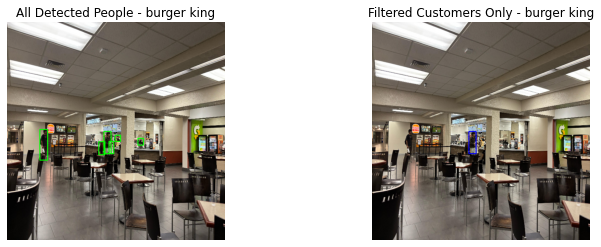

 11%|█████████▍                                                                         | 5/44 [00:09<01:06,  1.71s/it]

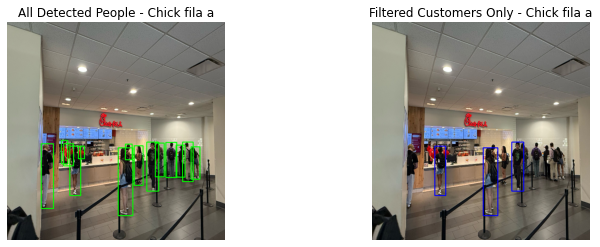

 23%|██████████████████▋                                                               | 10/44 [00:16<00:44,  1.32s/it]

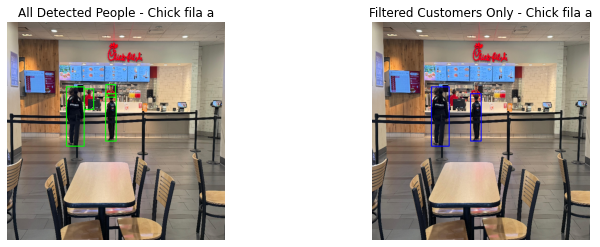

 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:36,  1.27s/it]

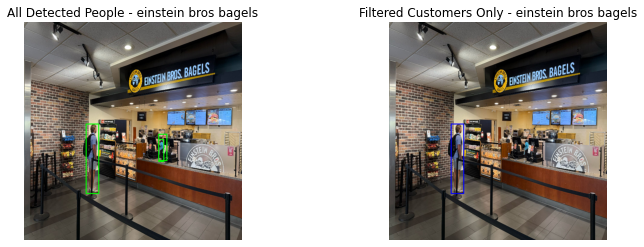

 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:36,  1.53s/it]

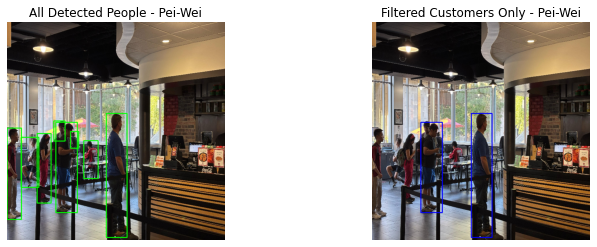

 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:25,  1.33s/it]

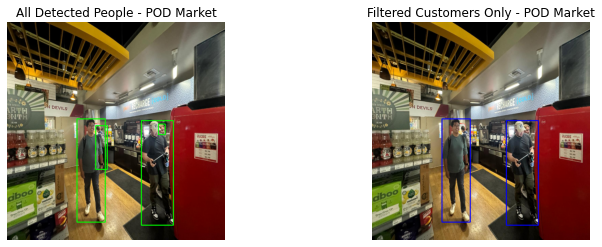

 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:17,  1.26s/it]

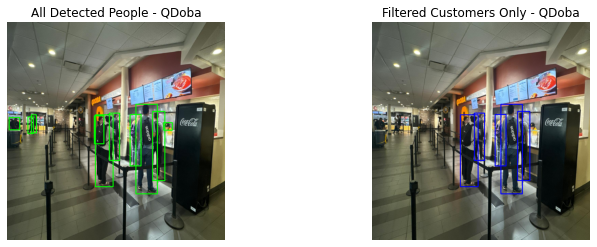

 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:12,  1.44s/it]

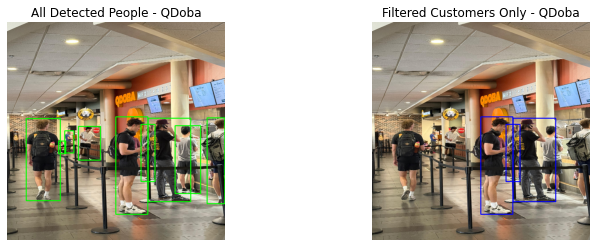

 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.41s/it]

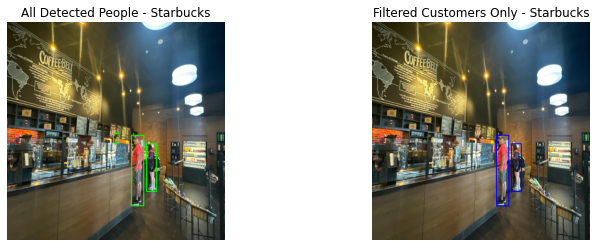

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.48s/it]


In [5]:
# Define Customer Filter Function
def is_customer(box, img_size, shop_name):
    img_width, img_height = img_size
    x1, y1, x2, y2 = map(int, box[:4])
    center_x = (x1 + x2) / 2
    box_height = y2 - y1

    # X-axis center filtering
    x_condition = (0.25 * img_width < center_x < 0.75 * img_width)

    # Shop-specific box height constraints
    if 'burger king' in shop_name.lower():
        height_condition = (box_height > 0.1 * img_height)
    elif ('chick-fil-a' in shop_name.lower()) or ('einstein bros bagels' in shop_name.lower()):
        height_condition = (box_height > 0.15 * img_height)
    else:
        height_condition = (box_height > 0.2 * img_height)

    return x_condition and height_condition

# Draw Bounding Boxes on Image
def draw_boxes(image, boxes, color=(0, 255, 0)):
    for box in boxes:
        x1, y1, x2, y2 = map(int, box[:4])
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    return image

# Iterate Through Each Image for Detection and Filtering
for i, row in tqdm(image_df.iterrows(), total=len(image_df)):
    img = cv2.imread(row['path'])
    img_resized = cv2.resize(img, (640, 640))
    img_size = (img_resized.shape[1], img_resized.shape[0])  # (width, height)

    results = model(img_resized, verbose=False)
    detections = results[0].boxes.data.cpu().numpy()
    people_boxes = [box for box in detections if int(box[5]) == 0]

    img_all = draw_boxes(img_resized.copy(), people_boxes, (0, 255, 0))

    shop_name = row['shop']  # Get shop name from dataframe
    customer_boxes = [box for box in people_boxes if is_customer(box, img_size, shop_name)]
    img_customers = draw_boxes(img_resized.copy(), customer_boxes, (255, 0, 0))

    all_counts.append(len(people_boxes))
    customer_counts.append(len(customer_boxes))

    if i % 5 == 0:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img_all, cv2.COLOR_BGR2RGB))
        plt.title(f"All Detected People - {shop_name}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(img_customers, cv2.COLOR_BGR2RGB))
        plt.title(f"Filtered Customers Only - {shop_name}")
        plt.axis('off')
        plt.show()

# Store Detection Counts to DataFrame
image_df['people_count'] = all_counts
image_df['customer_count'] = customer_counts


## Step 4: Simulate Waiting Time Based on Customer Count

In [6]:
# Set random seed for reproducibility
np.random.seed(42)

# Simulate waiting time for each image based on number of customers detected
# For each customer detected, assume 30 seconds average wait time
# Add random noise with mean 0 and standard deviation 10 seconds to simulate real-world randomness
image_df['waiting_time'] = image_df['customer_count'].apply(
    lambda x: int(30 * x + np.random.normal(0, 10)) if x > 0 else 0  # New: 30 sec mean, 10 sec std dev
)

# Calculate Average and Standard Deviation of Wait Time per Customer
valid_customers = image_df[image_df['customer_count'] > 0]
# Calculate average time per customer by dividing total wait time by total customers
average_time_per_customer = valid_customers['waiting_time'].sum() / valid_customers['customer_count'].sum()
# Calculate standard deviation for wait time per customer across images
std_dev_time_per_customer = np.std(valid_customers['waiting_time'] / (valid_customers['customer_count'] + 1e-5))

print(f"Average wait time per customer: {average_time_per_customer:.2f} seconds")
print(f"Standard deviation: {std_dev_time_per_customer:.2f} seconds")

# Predict Total Wait Time per Shop
# Group customer counts by shop and predict total wait time by multiplying with average time per customer
shop_grouped = image_df.groupby('shop').agg({
    'customer_count': 'sum'
}).reset_index()
shop_grouped['predicted_wait_time(seconds)'] = (shop_grouped['customer_count'] * average_time_per_customer).round(2)

# Add a new column for predicted wait time in minutes, rounded to 2 decimals
# If value is extremely close to 1 minute, round it exactly to 1.00
shop_grouped['predicted_wait_time(minutes)'] = (shop_grouped['predicted_wait_time(seconds)'] / 60).round(2)
shop_grouped['predicted_wait_time(minutes)'] = shop_grouped['predicted_wait_time(minutes)'].apply(lambda x: 1.00 if abs(x-1.0) < 0.05 else x)

# Display result
display(shop_grouped)

Average wait time per customer: 29.19 seconds
Standard deviation: 5.88 seconds


,shop,customer_count,predicted_wait_time(seconds),predicted_wait_time(minutes)
0,Chick fila a,24,700.50,11.68
1,Choolah,1,29.19,0.49
2,Gigis,5,145.94,2.43
3,POD Market,16,467.00,7.78
4,Pei-Wei,6,175.12,2.92
5,QDoba,25,729.69,12.16
6,Starbucks,10,291.88,4.86
7,burger king,4,116.75,1.95
8,einstein bros bagels,5,145.94,2.43
9,subway,0,0.00,0.00


## Step 5: Visualize Results

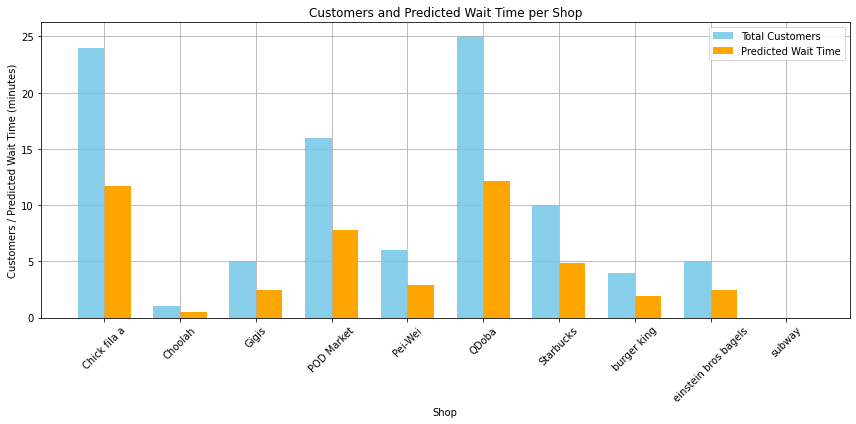

In [7]:
# Bar chart: total customers vs predicted wait time
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.35
x = np.arange(len(shop_grouped))

bars1 = ax.bar(x - width/2, shop_grouped['customer_count'], width, label='Total Customers', color='skyblue')
bars2 = ax.bar(x + width/2, shop_grouped['predicted_wait_time(minutes)'], width, label='Predicted Wait Time', color='orange')

ax.set_xlabel('Shop')
ax.set_ylabel('Customers / Predicted Wait Time (minutes)')
ax.set_title('Customers and Predicted Wait Time per Shop')
ax.set_xticks(x)
ax.set_xticklabels(shop_grouped['shop'], rotation=45)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

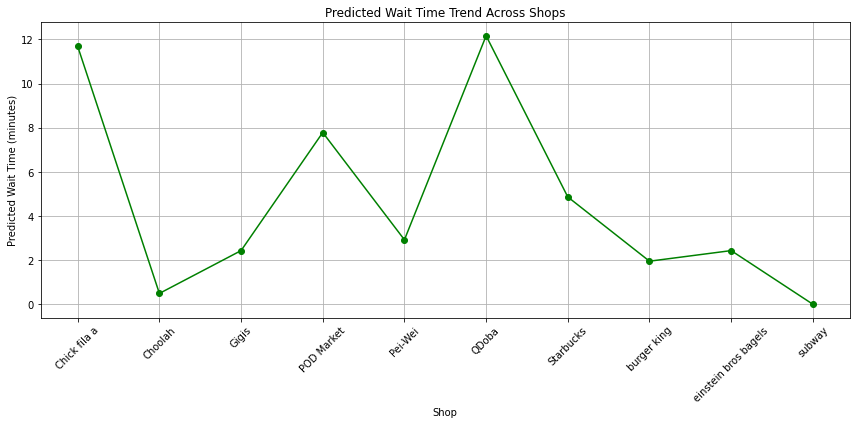

In [8]:
# Line chart: Predicted Wait Time (in Minutes)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(shop_grouped['shop'], shop_grouped['predicted_wait_time(minutes)'], marker='o', linestyle='-', color='green')
ax.set_xlabel('Shop')
ax.set_ylabel('Predicted Wait Time (minutes)')
ax.set_title('Predicted Wait Time Trend Across Shops')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

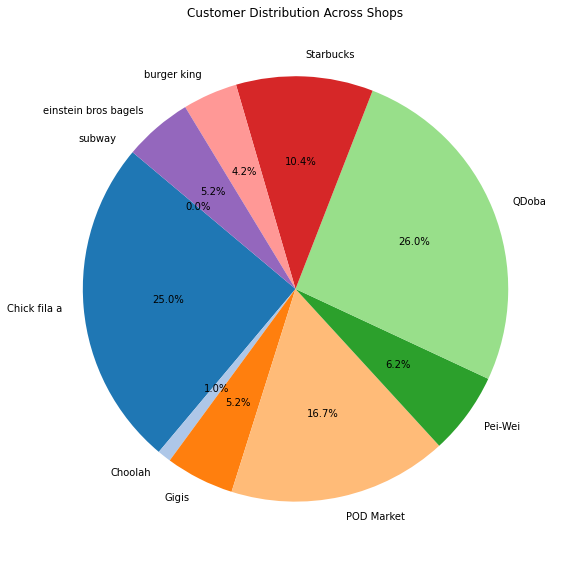

In [9]:
# Pie Chart: Distribution of Customers Across Shops
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(shop_grouped['customer_count'], labels=shop_grouped['shop'], autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
ax.set_title('Customer Distribution Across Shops')
plt.tight_layout()
plt.show()

# Future Scope

Current pre-trained YOLO models miss occasional customers standing in queues, due to non-ideal poses or occlusion. Future work can include fine-tuning models specifically on university eatery queues to improve detection robustness